In [61]:
import os
def read_config(section, name=None, environment_variable=None, default=None, config_file_path='../../augur.config.json', no_config_file=0, use_main_config=0):
    """
    Read a variable in specified section of the config file, unless provided an environment variable

    :param section: location of given variable
    :param name: name of variable
    """
    _config_file_name = 'augur.config.json'
    _config_bad = False
    _already_exported = {}
    _runtime_location = 'runtime/'
    _default_config = {}
    _config_file = None

    try:
        _config_file = open(config_file_path, 'r+')
    except:
        print('Couldn\'t open {}'.format(_config_file_name))

    # Load the config file
    try:
        config_text = _config_file.read()
        _config = json.loads(config_text)
    except json.decoder.JSONDecodeError as e:
        if not _config_bad:
            _using_config_file = False
            print('{} could not be parsed, using defaults. Fix that file, or delete it and run this again to regenerate it. Error: {}'.format(config_file_path, str(e)))
        _config = _default_config

    value = None
    if environment_variable is not None:
        value = os.getenv(environment_variable)
    if value is None:
        try:
            if name is not None:
                value = _config[section][name]
            else:
                value = _config[section]
        except Exception as e:
            value = default
            if not section in _config:
                _config[section] = {}

    return value

In [73]:
time_series = {'closed-issues-count':['date','closed_count'],
               'code-changes':['date','commit_count'],
               'code-changes-lines':['date','added','removed'],
               'issues-active':['date','issues'],
               'issues-closed':['date','issues'],
               'contributors-new':['date','new_contributors'],
               'reviews':['date','pull_requests']}
columns = ['date','closed_issue_count','commit_count','added','removed','issues_active','issues_closed','new_contributors','pull_requests']

import pandas as pd
import requests
import datetime
import json
training_days = 365
repo_id = 25430
augur_api_host = read_config("Server", "host", "AUGUR_HOST", "0.0.0.0",config_file_path='/Users/pratikmishra/augur/augur.config.json')
augur_api_port = read_config("Server", "port", "AUGUR_PORT", 5000,config_file_path='/Users/pratikmishra/augur/augur.config.json')
base_url = 'http://{}:{}/api/unstable/repo-groups/20/repos/{}/'.format(augur_api_host,augur_api_port,repo_id)

def collect_data(category):
    if(category==time_series):
        df = pd.DataFrame(columns=['date'])
        
    for endpoint in category.keys():
    
        url = base_url + endpoint
        print("Hitting endpoint: " + url + "\n")

        data = requests.get(url=url).json()
    
        if len(data) == 0:
            print("Endpoint with url: {} returned an empty response. Moving on to next endpoint.\n".format(url))
            continue
                    
        metric_df = pd.DataFrame.from_records(data)
        metric_df['date'] = pd.to_datetime(metric_df['date']).dt.date
    
        df = pd.DataFrame(pd.merge(df,metric_df.loc[:,category[endpoint]],how = 'outer',on = 'date'))

    return df


time_data = collect_data(time_series)
time_data.columns = columns

Hitting endpoint: http://0.0.0.0:5000/api/unstable/repo-groups/20/repos/25430/closed-issues-count

Hitting endpoint: http://0.0.0.0:5000/api/unstable/repo-groups/20/repos/25430/code-changes

Hitting endpoint: http://0.0.0.0:5000/api/unstable/repo-groups/20/repos/25430/code-changes-lines

Hitting endpoint: http://0.0.0.0:5000/api/unstable/repo-groups/20/repos/25430/issues-active

Hitting endpoint: http://0.0.0.0:5000/api/unstable/repo-groups/20/repos/25430/issues-closed

Hitting endpoint: http://0.0.0.0:5000/api/unstable/repo-groups/20/repos/25430/contributors-new

Hitting endpoint: http://0.0.0.0:5000/api/unstable/repo-groups/20/repos/25430/reviews



In [74]:

# Data is not regular that's why I had taken all the data points otherwise we will initialse df data frame
# with given number of training days with the following method:

#begin_date = datetime.datetime.now().replace(hour=0, minute=0, second=0, microsecond=0) - datetime.timedelta(days=training_days)
#begin_date = begin_date.strftime('%Y-%m-%d')
#index = pd.date_range(begin_date, periods=training_days, freq='D')
#df = df.reset_index()
#df.columns = ['date']
#df['date'] = pd.to_datetime(df['date']).dt.date
#df.date.astype(str)

#this will merge metric_df with previous 365 daya

In [75]:
time_data = time_data.sort_values(by='date')
time_data = time_data.set_index('date')
#time_data.reset_index(inplace=True,drop=True)
time_data = time_data.fillna(0)

time_data.head()

,closed_issue_count,commit_count,added,removed,issues_active,issues_closed,new_contributors,pull_requests
date,,,,,,,,
2017-01-04,0.0,1.0,18.0,2.0,0.0,0.0,0.0,0.0
2017-01-09,0.0,5.0,646.0,551.0,0.0,0.0,0.0,0.0
2017-01-10,0.0,1.0,59.0,23.0,0.0,0.0,0.0,0.0
2017-01-11,0.0,1.0,85.0,24.0,0.0,0.0,0.0,0.0
2017-01-16,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
# make another copy of data and then scale it.
from sklearn.preprocessing import MinMaxScaler
df = time_data.copy()
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df))
df.columns = ['closed_issue_count','commit_count','added','removed','issues_active','issues_closed','new_contributors','pull_requests']
df.describe()

,closed_issue_count,commit_count,added,removed,issues_active,issues_closed,new_contributors,pull_requests
count,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000,647.000000
mean,0.023897,0.125460,0.012958,0.010431,0.036698,0.034518,0.035549,0.035549
std,0.084556,0.165826,0.065266,0.062363,0.089495,0.104422,0.142850,0.087079
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.017241,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.068966,0.000309,0.000081,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.172414,0.002218,0.001005,0.038462,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [77]:
time_data.columns

Index(['closed_issue_count', 'commit_count', 'added', 'removed',
       'issues_active', 'issues_closed', 'new_contributors', 'pull_requests'],
      dtype='object')

In [80]:
df.index = time_data.index
df.head()

,closed_issue_count,commit_count,added,removed,issues_active,issues_closed,new_contributors,pull_requests
date,,,,,,,,
2017-01-04,0.000000,0.034483,0.000071,0.000006,0.0,0.0,0.0,0.0
2017-01-09,0.000000,0.172414,0.002557,0.001716,0.0,0.0,0.0,0.0
2017-01-10,0.000000,0.034483,0.000234,0.000072,0.0,0.0,0.0,0.0
2017-01-11,0.000000,0.034483,0.000336,0.000075,0.0,0.0,0.0,0.0
2017-01-16,0.230769,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


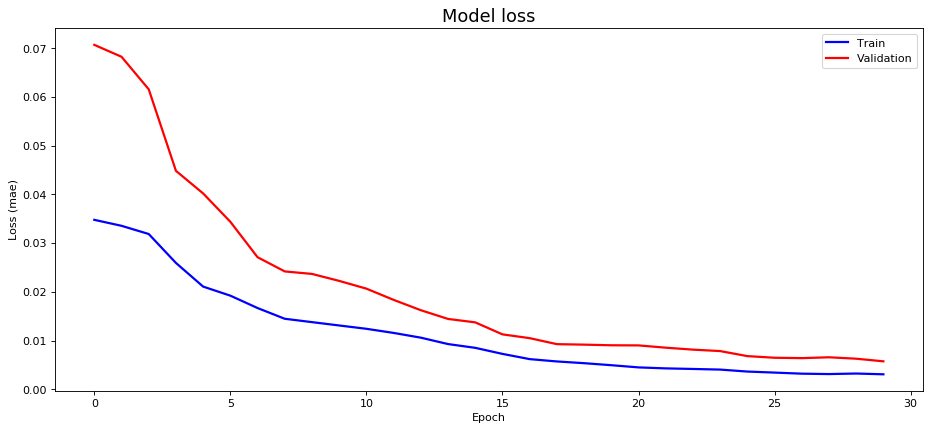

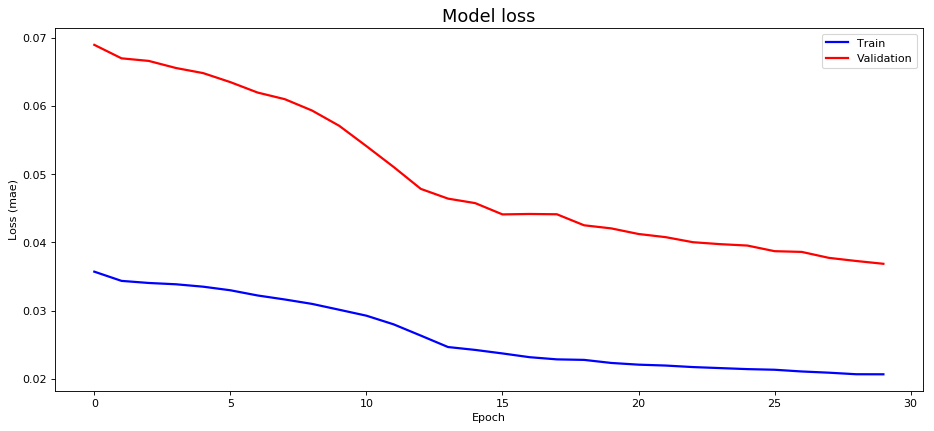

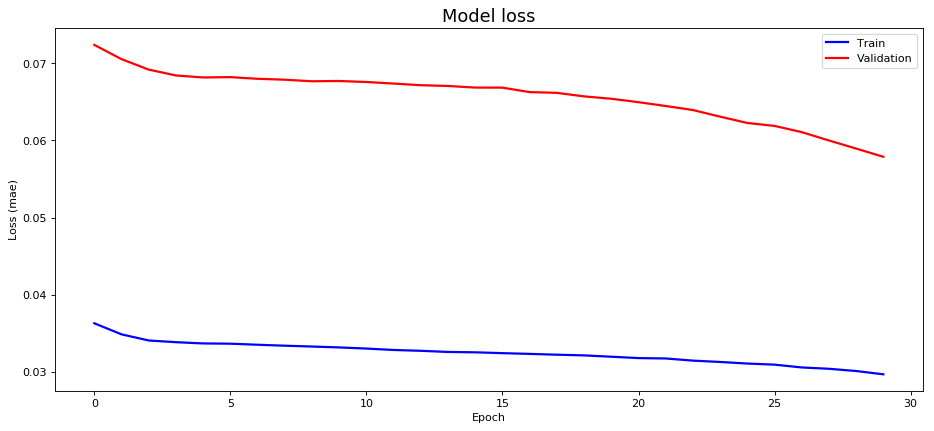

In [81]:
#implement Stakced LSTM model with additional dense layer to predict every columns
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
from numpy import hstack
import seaborn as sns
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
%matplotlib inline
look_back_days = [1,3,7]  #number of datapoints it will look back to predict next data point


def lstm_model(data,days,threshold):
    
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(days, data.shape[1])))
    model.add(LSTM(50, activation='relu',return_sequences=True))
    model.add(Dense(data.values.shape[1]))
    model.compile(optimizer='adam', loss='mae')
    return model
    




for days in look_back_days:
    data = df.iloc[0:(int(df.shape[0]/days)*days)]
    X_train = data.values.reshape(int(data.values.shape[0]/days),days, data.shape[1])
    nb_epochs = 30
    batch_size = 10
    model_value = lstm_model(data,days,0.07).fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.08,verbose=0).history
    fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
    ax.plot(model_value['loss'], 'b', label='Train', linewidth=2)
    ax.plot(model_value['val_loss'], 'r', label='Validation', linewidth=2)
    ax.set_title('Model loss', fontsize=16)
    ax.set_ylabel('Loss (mae)')
    ax.set_xlabel('Epoch')
    ax.legend(loc='upper right')
    plt.show()

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(0.0, 0.2)

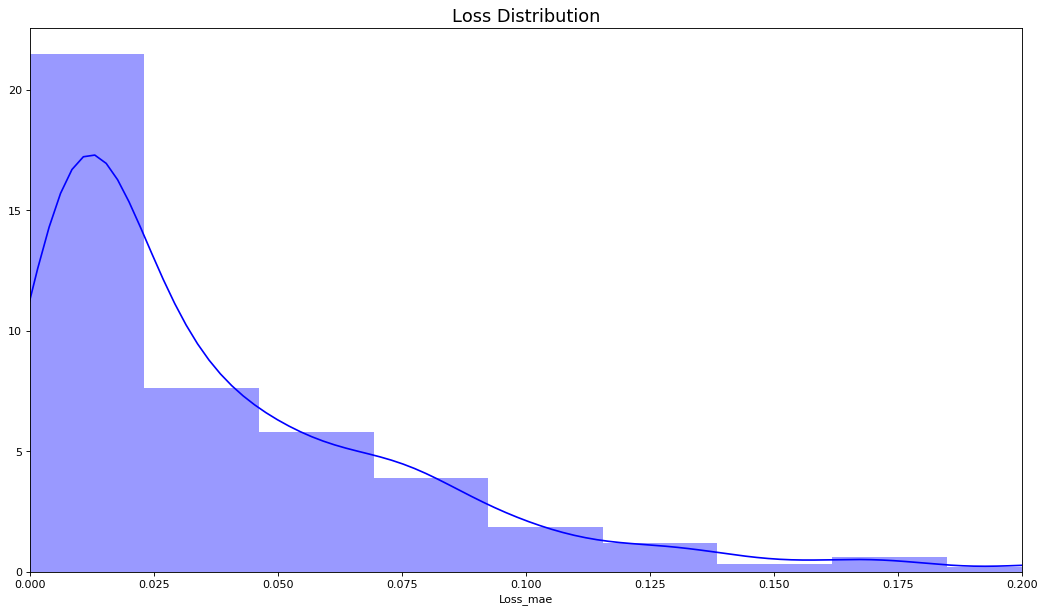

In [82]:
# We can see that when look_back_days is equal to 1 then model have less erros between train and validation
#and it performs better
# so we will select look_back_days = 1
days = 1
nb_epochs = 30

batch_size = 10

data = df.iloc[0:(int(df.shape[0]/days)*days)]

X_train = data.values.reshape(int(data.values.shape[0]/days),days, data.shape[1])

model_value = lstm_model(data,days,0.07).fit(X_train,X_train,epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.08,verbose=0)

X_pred = lstm_model(data,days,0.07).predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0]*days, X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=df.columns)
X_pred.index = df.index

scored = pd.DataFrame(index=df.index)
Xtrain = X_train.reshape(X_train.shape[0]*days, X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 10, kde= True, color = 'blue');
plt.xlim([0.0,.2])

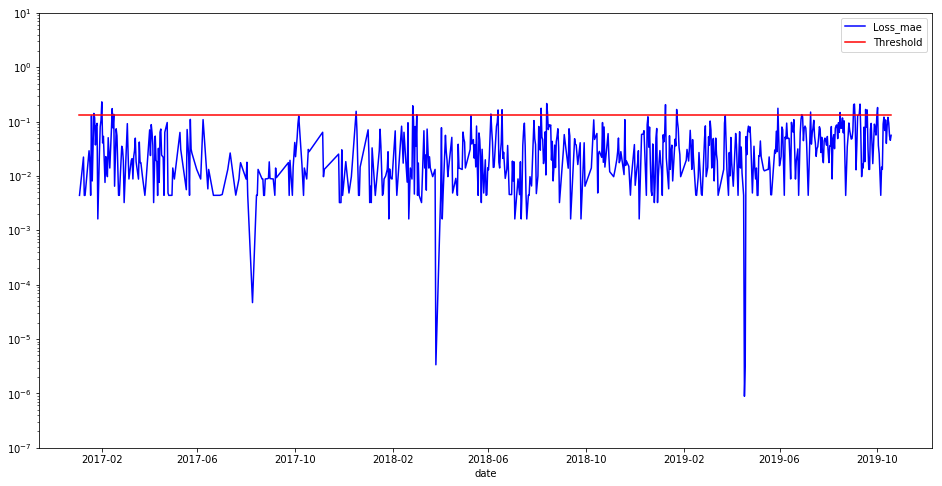

In [83]:


scored_train = pd.DataFrame(index=df.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
scored_train['Threshold'] = 0.13
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
    
scored_train.plot(logy=True,  figsize=(16,8), ylim=[1e-7,1e1], color=['blue','red'])
    

In [84]:
scored_train.Anomaly.value_counts()

False    620
True      27
Name: Anomaly, dtype: int64

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


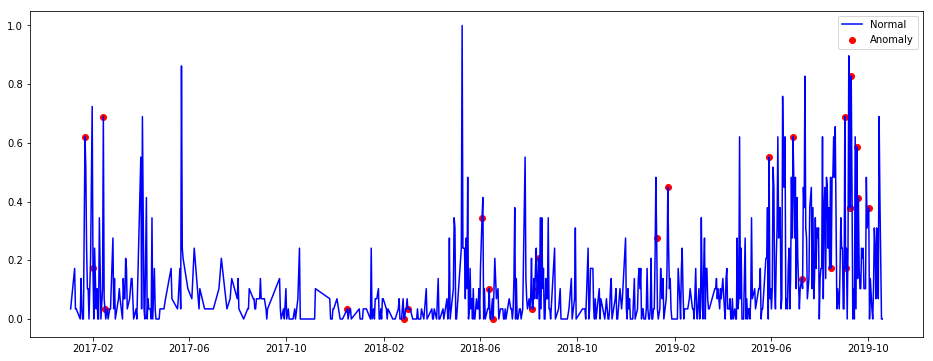

In [85]:
pd.plotting.register_matplotlib_converters()
fig, ax = plt.subplots(figsize=(16,6))
ano = df.loc[scored_train['Anomaly'] == True, columns] #anomaly
#ano['date'] = time_data.loc[scored_train['Anomaly'] == True, ['date']] #anomaly
#ano['date'] = ano['date'].astype(object)
#ano  = ano.set_index('date')
ax.plot(df.index, df['commit_count'], color='blue', label = 'Normal')#anomaly points with "added" values
ax.scatter(ano.index,ano['commit_count'], color='red', label = 'Anomaly')
#plt.title('Anomaly with Commit_count', fontsize=16)
plt.legend()
plt.show();

In [86]:
ano.head()

,date,closed_issue_count,commit_count,added,removed,issues_active,issues_closed,new_contributors,pull_requests
date,,,,,,,,,
2017-01-22,NaN,0.0,0.620690,0.000835,0.000639,0.000000,0.000000,0.5,0.000000
2017-02-01,NaN,0.0,0.172414,0.000020,0.000016,0.000000,0.222222,1.0,0.444444
2017-02-14,NaN,0.0,0.689655,0.001896,0.000249,0.076923,0.111111,0.5,0.000000
2017-02-16,NaN,0.0,0.034483,0.000479,0.000121,0.217949,0.333333,0.5,0.000000
2017-12-17,NaN,0.0,0.034483,0.228797,0.000031,0.423077,0.555556,0.0,0.000000


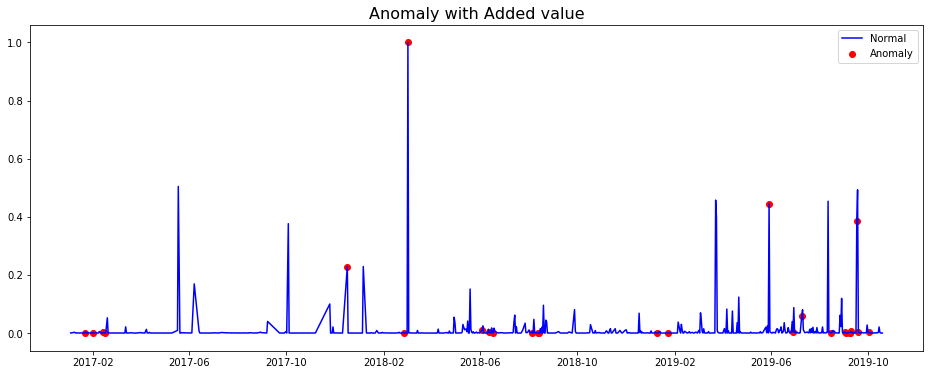

In [88]:
fig, ax = plt.subplots(figsize=(16,6))

ax.plot(df.index, df['added'], color='blue', label = 'Normal')#anomaly points with "added" values
ax.scatter(ano.index,ano['added'], color='red', label = 'Anomaly')
plt.title('Anomaly with Added value', fontsize=16)
plt.legend()
plt.show();

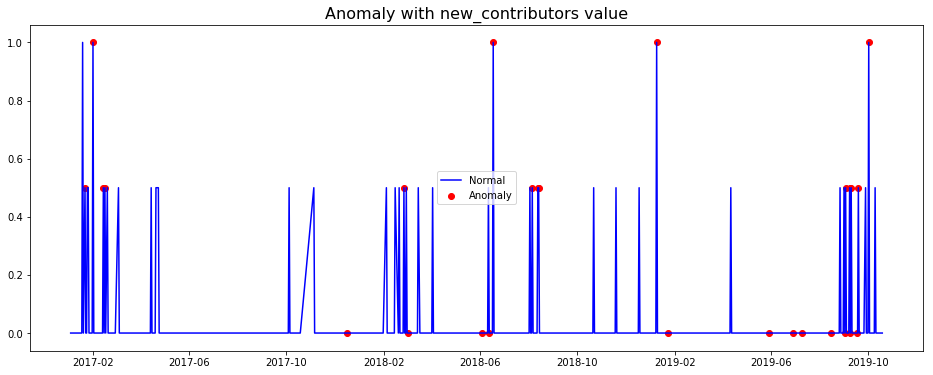

In [89]:
fig, ax = plt.subplots(figsize=(16,6))

ax.plot(df.index, df['new_contributors'], color='blue', label = 'Normal')#anomaly points with "added" values
ax.scatter(ano.index,ano['new_contributors'], color='red', label = 'Anomaly')
plt.title('Anomaly with new_contributors value', fontsize=16)
plt.legend()
plt.show();

In [90]:
df_error = pd.DataFrame(np.abs(df-X_pred))
df_error.columns = df.columns
df_error.head()

,closed_issue_count,commit_count,added,removed,issues_active,issues_closed,new_contributors,pull_requests
date,,,,,,,,
2017-01-04,0.000092,0.034461,0.000153,0.000092,0.000085,0.000024,0.000187,0.000124
2017-01-09,0.000465,0.172299,0.001435,0.002143,0.000430,0.000117,0.000933,0.000620
2017-01-10,0.000092,0.034461,0.000009,0.000158,0.000085,0.000024,0.000186,0.000124
2017-01-11,0.000092,0.034460,0.000112,0.000161,0.000085,0.000024,0.000186,0.000124
2017-01-16,0.230203,0.000054,0.000548,0.000033,0.000483,0.000494,0.000823,0.000442


In [91]:
df_anomaly_error = df_error.loc[scored_train['Anomaly'] == True, df_error.columns]


df_fraction_error = pd.DataFrame()
for i in df_error.columns:
    df_fraction_error[i]=(df_anomaly_error[i])/(df_anomaly_error[list(df_error.columns)].sum(axis=1))

In [92]:
df_fraction_error.head()

,closed_issue_count,commit_count,added,removed,issues_active,issues_closed,new_contributors,pull_requests
date,,,,,,,,
2017-01-22,0.001415,0.545077,0.003060,0.001199,0.001837,0.002074,0.443383,0.001955
2017-02-01,0.001178,0.091448,0.001144,0.000235,0.000277,0.121192,0.542594,0.241932
2017-02-14,0.001131,0.494147,0.001704,0.000714,0.057177,0.081592,0.361682,0.001853
2017-02-16,0.000058,0.030352,0.000793,0.000103,0.200288,0.306266,0.460279,0.001860
2017-12-17,0.000044,0.024948,0.184259,0.000217,0.341617,0.447786,0.000126,0.001003


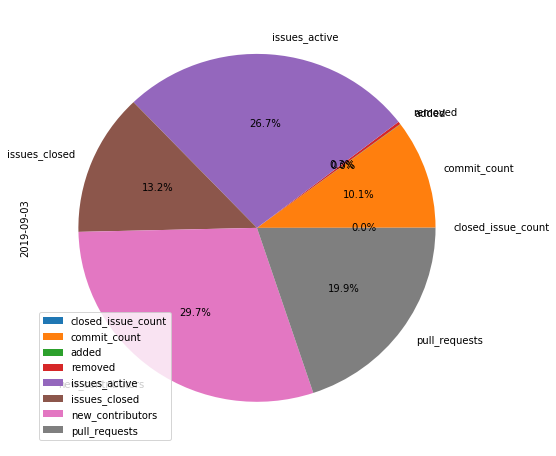

In [99]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,8)
df_anomaly_error.iloc[20].plot(kind='pie',ax=ax,autopct='%1.1f%%' )
plt.legend(loc = 'lower left')
#ax.set_ylabel()
#ax.set_xlabel()
